In [269]:
import os
import xml.etree.ElementTree as ET
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
from PIL import Image, ImageDraw, ImageFont
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split, Subset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.resnet import resnet50
from torchvision.transforms import functional as F
from torchvision.ops import nms
import torchvision.transforms as T
import torchvision
import pandas as pd
import cv2
import json
from collections import defaultdict

os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [335]:
with open('label_maps.json', 'r') as json_file:
    label_maps = json.load(json_file)

In [336]:
label_name = {v : k for k, v in label_maps.items()}

In [337]:
root_path = '.\\dumpsite_data\\VOC2012'
train_path = os.path.join(root_path, "train")
test_path = os.path.join(root_path, "test")
train_file_Annotations = os.path.join(train_path, "Annotations")
test_file_Annotations = os.path.join(test_path, "Annotations")

In [338]:
def find_the_classes(path): 
    object_class = []
    for each_xml in os.listdir(path):
        pic_xml = os.path.join(path, each_xml)
        tree = ET.parse(pic_xml)
        root = tree.getroot()
        for object_elem in root.findall('object'):
            name_elem_value = object_elem.find('name').text
            object_class.append(name_elem_value)
    classes = set(object_class)
    print(classes)
    return object_class

train_object_class = find_the_classes(train_file_Annotations)
test_object_class = find_the_classes(test_file_Annotations)

{'disposed garbage', 'industry waste', 'agriculture forestry', 'construction waste', 'domestic garbage', 'mining waste'}
{'disposed garbage', 'agriculture forestry', 'domestic garbage', 'construction waste'}


In [339]:
name_number = defaultdict(int)
for index, class_name in enumerate(train_object_class):
    name_number[label_maps[class_name]] += 1
    train_object_class[index] = label_maps[class_name]
classes_weights = defaultdict(float, { key: (1. / value if value != 0 else float('inf')) for key, value in name_number.items()})

In [404]:
classes_weights[5] = 0.0001
classes_weights[4] = 0.0001

In [341]:
df = pd.Series(data=name_number.values(), index=list(label_name[name] for name in name_number.keys()))
df

agriculture forestry     247
construction waste       581
domestic garbage        2301
industry waste             1
disposed garbage           9
mining waste               1
dtype: int64

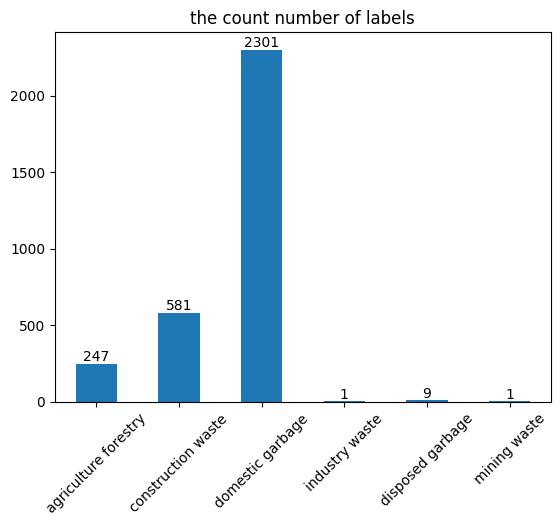

In [342]:
ax = df.plot.bar(rot=45)
for container in ax.containers:
    ax.bar_label(container, label_type='edge')
plt.title("the count number of labels")
plt.show()

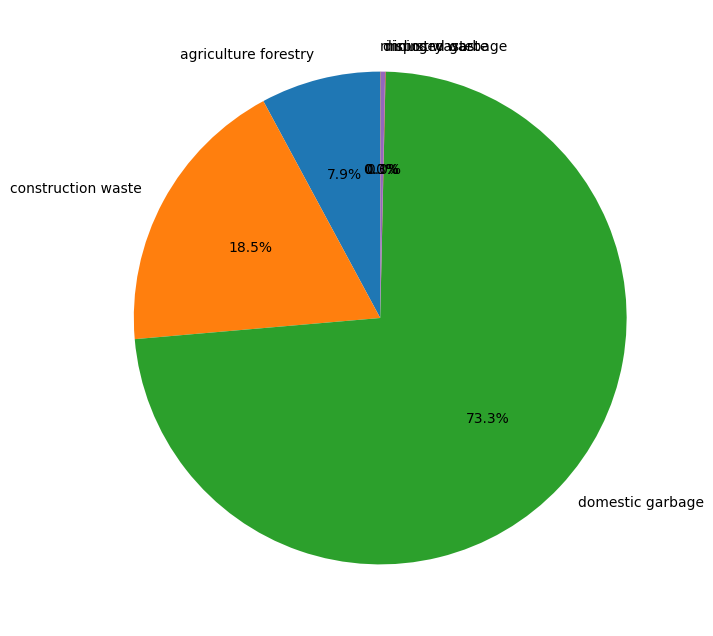

In [344]:
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(name_number.values(), labels=list(label_name[name] for name in name_number.keys()), autopct='%1.1f%%', startangle=90)
for text in texts:
    text.set_fontsize(10)
    text.set_color('black')
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('black')
plt.show()

##### Due to the problem of severe sample imbalance in the dumpsite dataset (Fig. 1a), we propose two training strategies, data augmentation (vertical flipping, horizontal
##### flipping, forward 90° rotation and reverse 90° rotation) and category balancing, to ensure the model’sefficiency during the training process

In [347]:
class Customdataset(Subset):
    def __init__(self, dataset, indices):
        super().__init__(dataset, indices)
        self.dataset = dataset
        self.indices = indices
        
    def compare_pic(self, idx=None):
        if idx is None:
            random_idx = random.randint(0, len(self.indices) - 1)
        else:
            random_idx = idx
        original_idx = self.indices[random_idx]
        self.dataset.compare_pic(original_idx)
    
    def load_annotations(self):
        annotations = [self.dataset.load_annotations()[i] for i in self.indices]
        return annotations

In [349]:
class  VOCDataset(Dataset):
    """
    The VOCDataset will attempt to load the dataset of the Pascal VOC format
    """
    def __init__(self, root, transforms, mode):
        self.root = root
        self.transforms = transforms
        if mode == "train":
            txt_file = os.path.join(root, "train.txt")
            self.status = "train"
        elif mode == "val":
            txt_file = os.path.join(root, "train.txt")
            self.status = "val"
        else:
            txt_file = os.path.join(root, "test.txt")
            self.status = "test"
        with open(txt_file, 'r') as f:
            self.image_ids = f.read().strip().split()
        self.image_folder = os.path.join(root, "JPEGImages")
        self.ann_folder = os.path.join(root, "Annotations")
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        """
        The __getitem__ function will attempt to load the specific image after pre-processing
        Args:
            idx (int) : the index of the image
        Returns:
            dict : image, boxes, labels
        """
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_folder, f"{img_id}.jpg")
        ann_path = os.path.join(self.ann_folder, f"{img_id}.xml")

        img = np.array(Image.open(img_path).convert("RGB"))
        tree = ET.parse(ann_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.findall("object"):
            label = obj.find("name").text
            labels.append(label_maps[label])
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            box = [xmin, ymin, xmax, ymax]
            boxes.append(box)
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {"boxes":boxes, "labels":labels}
        if self.status == "train":
            while True:
                img_copy, target_copy = img.copy(), target.copy()
                transformed = self.transforms(image=img_copy, bboxes=target_copy['boxes'].tolist(), labels=target_copy['labels'].tolist())
                img_copy = transformed['image']
                target_copy['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
                target_copy['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)
                if torch.numel(target_copy['boxes']) > 0:
                    img, target = img_copy, target_copy
                    break
        else:
            img = self.transforms(img)
        return {'image':img, 'boxes':target['boxes'], 'labels':target['labels']}

    def _unnormalize(self, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        """
        _unnormalize function will attempt to recover the image which has been normalized.
        Args:
            image (torch) : the image would be unnormalized.
            mean (torch) : the default mean value.
            std (torch) : the default std value.
        Returns:
            torch : the unnormalized image
        """
        mean = torch.tensor(mean)[:, None, None]
        std = torch.tensor(std)[:, None, None]
        return image * std + mean

    def compare_pic(self, idx=None):
        """
        compare_pic will attempt to show the original image and the image after pre-processing through visualization.
        Args:
            idx (int) : random image or a specific image.
        Returns:
            plots : two plots.
        """
        if idx == None:
            random_idx = random.randint(0, len(self.image_ids) - 1)
        else:
            random_idx = idx
        
        if self.status == "train":
            ori_pic = os.path.join("./dumpsite_data/VOC2012/train/JPEGImages", f'{self.image_ids[random_idx]}.jpg')
            ori_pic_ann = os.path.join("./dumpsite_data/VOC2012/train/Annotations", f"{self.image_ids[random_idx]}.xml")
        else:
            ori_pic = os.path.join("./dumpsite_data/VOC2012/test/JPEGImages", f'{self.image_ids[random_idx]}.jpg')
            ori_pic_ann = os.path.join("./dumpsite_data/VOC2012/test/Annotations", f"{self.image_ids[random_idx]}.xml")
        ori_pic = Image.open(ori_pic).convert("RGB")
        tree = ET.parse(ori_pic_ann)
        root = tree.getroot()
        ori_boxes = []
        ori_labels = []
        for bounding_box in root.findall('object'):
            label = bounding_box.find("name").text
            ori_labels.append(label)
            bbox = bounding_box.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            box = [xmin, ymin, xmax, ymax]
            ori_boxes.append(box)
        ori_draw = ImageDraw.Draw(ori_pic)
        for box, label in zip(ori_boxes, ori_labels):
            xmin, ymin, xmax, ymax = box
            ori_draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=10)
            ori_draw.text((xmin - 10, ymin - 10), label, fill="red")
            
        sample = self[random_idx]
        if sample:
            image, boxes, labels = sample['image'], sample['boxes'], sample['labels']
            image = self._unnormalize(image).permute(1, 2, 0).numpy()
            image = (image * 255).astype(np.uint8)
            image = F.to_pil_image(image)
            draw = ImageDraw.Draw(image)
            for box, label in zip(boxes, labels):
                xmin, ymin, xmax, ymax = box
                draw.rectangle([xmin, ymin, xmax, ymax], outline="black", width=10)
                draw.text((xmin - 10, ymin - 10), label_name(label), fill="black")

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            ax1.imshow(ori_pic)
            ax1.set_title('ori_pic')
            ax2.imshow(image)
            ax2.set_title('after_pic')
            plt.show()

    def load_annotations(self):
        """
        load_annotations function attempt to store the classes appeared in each image to recompute the image weight
        Returns:
            list : the labels in each image
        """
        data_infos = []
        for index in self.image_ids:
            ann_path = os.path.join(self.ann_folder, f"{index}.xml")
            tree = ET.parse(ann_path)
            root = tree.getroot()
            temp_labels = []
            for obj in root.findall("object"):
                label = obj.find("name").text
                temp_labels.append(label_maps[label])
            data_infos.append(temp_labels)
        return data_infos

In [350]:
transform = {
    "train" : A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    A.Rotate(limit=-90, p=0.5), 
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])),
    "test" : T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
}

In [351]:
def collate_fn(batch):
    images = []
    targets = []
    for obj in batch:
        if obj:
            images.append(obj['image'])
            targets.append({'boxes':obj['boxes'], 'labels':obj['labels']})
    images = torch.stack(images, dim=0)
    return images, targets


# transforms = DetectionTransforms()
train_dataset = VOCDataset(root='./dumpsite_data/VOC2012/train', transforms=transform["train"], mode="train")
val_dataset = VOCDataset(root='./dumpsite_data/VOC2012/train', transforms=transform["test"], mode="val")

In [396]:
validation_split = 0.2
dataset_size = len(train_dataset)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

In [397]:
train_subset = Customdataset(train_dataset, train_indices)
val_subset = Customdataset(val_dataset, val_indices)

In [398]:
classes_weights

defaultdict(float,
            {1: 0.004048582995951417,
             2: 0.0017211703958691911,
             0: 0.000434593654932638,
             5: 0,
             3: 0.1111111111111111,
             4: 0})

In [406]:
annotations = train_dataset.load_annotations()
image_weights = []
for img_classes in annotations:
    img_weight = np.mean([classes_weights[cls] for cls in img_classes])
    image_weights.append(img_weight)

In [408]:
train_image_weights = [image_weights[i] for i in train_subset.indices]
sampler = WeightedRandomSampler(weights=train_image_weights, num_samples=len(train_image_weights), replacement=True)
train_dataloader = DataLoader(train_subset, batch_size=8, collate_fn=collate_fn, sampler=sampler)
val_dataloader = DataLoader(val_subset, batch_size=8, collate_fn=collate_fn)
test_dataset = VOCDataset(root='./dumpsite_data/VOC2012/test', transforms=transform["test"], mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

#### 原图与处理后的图片对比（含有边框）

In [21]:
# num_classes = 6
# model = fasterrcnn_resnet50_fpn(pretrained=True)
# input_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, num_classes=num_classes)

In [297]:
def decode_output(output, threshold=0.3, score_threshold=0.2):
    """
    decode_output function attempts to change the tensor into the numpy format and save the boxes and relative label which has high confidence by NMS
    Args:
        output : the output of the fastrcnn_model {boxes, labels, scores}
    Returns:
        list : boxes, list : scores(confidence), list : labels
    """
    boxes = output["boxes"].cpu().detach().numpy().astype(np.float32)
    labels = np.array([label_name[i] for i in output["labels"].cpu().detach().numpy()])
    scores = output["scores"].cpu().detach().numpy()
    boxes = boxes[scores >= score_threshold]
    labels = labels[scores >= score_threshold]
    scores = scores[scores >= score_threshold]
    indexes = nms(torch.tensor(boxes), torch.tensor(scores), threshold)
    boxes, labels, scores = [tensor[indexes.tolist()] for tensor in [boxes, labels, scores]]
    return boxes.tolist(), labels.tolist(), scores.tolist()

In [280]:
def plot_boxes_scores_labels(image, boxes, scores, labels):
    """
    Plot bounding boxes, confidence scores, and labels on an image.
    
    Parameters:
      image: The image on which to plot (numpy array).
      bbs: List of bounding boxes, each in the form [x, y, width, height].
      confs: List of confidence scores for each bounding box.
      labels: List of labels for each bounding box.
      label_colors: Optional dictionary mapping labels to colors.
    
    Returns:
      Image with bounding boxes, confidence scores, and labels plotted.
    """
    image = unnormalize(image).permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8)
    image = F.to_pil_image(image)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype("arial.ttf", 40)
    if not isinstance(boxes, list):
        boxes = boxes.tolist()
    for box, label, score in zip(boxes, labels, scores):
        xmin, ymin, xmax, ymax = box
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=10)
        draw.text((xmin - 40, ymin - 40), f"{label} {score}", fill="red", font=font)
    return image

## train part

In [24]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = fasterrcnn_resnet50_fpn(pretrained=False).to(device)
# backbone = model.backbone.body
# checkpoint_path = './fasterrcnn_resnet50_fpn.pth'
# model.load_state_dict(torch.load(checkpoint_path, map_location=device))
# num_classes = 6
# input_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, num_classes=num_classes)

In [ ]:
from model import ResNet50_CBAM
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = ResNet50_CBAM()

for param in list(backbone.backbone.children())[:5]:
    for p in param.parameters():
        p.requires_grad = False

backbone.out_channels = 256

rpn_anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256), (32, 64, 128, 256), (32, 64, 128, 256), (32, 64, 128, 256)),
    aspect_ratios=((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)),
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0', '1', '2', '3'],  # Use FPN layers
    output_size=7,
    sampling_ratio=2,
)

model = FasterRCNN(
    backbone,
    num_classes=7,
    rpn_anchor_generator=rpn_anchor_generator,
    box_roi_pool=roi_pooler,
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [22]:
for param in list(backbone.backbone.children())[:5]:
    for p in param.parameters():
        p.requires_grad = False
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params=params, lr=0.0025, momentum=0.9, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.1)
epochs = 21
train_loss_epochs = []
val_loss_epochs = []
best_valid_loss = float("inf")

In [409]:
# 测试在权重变化后各个标签都会取到多少个


one_epoch_class_number = defaultdict(int)
for epoch in range(1):
    for images, targets in train_dataloader:
        for image, target in zip(images, targets):
            labels = target["labels"].numpy()
            for label in labels:
                one_epoch_class_number[label] += 1
print(one_epoch_class_number)

defaultdict(<class 'int'>, {2: 645, 1: 705, 3: 531, 0: 944})


In [410]:
key_mapping = {label_name[k] : v for k, v in one_epoch_class_number.items()}
key_mapping 

{'construction waste': 645,
 'agriculture forestry': 705,
 'disposed garbage': 531,
 'domestic garbage': 944}

In [58]:
for epoch in range(epochs):
    model.train()
    train_loss_epoch = []
    for images, targets in train_dataloader:
        images = list(image.to(device) for image in images)
        filtered_images = []
        filtered_targets = []
        for image, target in zip(images, targets):
            # if target['boxes'].numel() > 0:
            filtered_images.append(image)
            filtered_targets.append({box: label.to(device) for box, label in target.items()})
        optimizer.zero_grad()
        loss = model(filtered_images, filtered_targets)
        losses = sum(loss for loss in loss.values())
        losses.backward()
        optimizer.step()
        train_loss_epoch.append(losses.item())
    train_loss_epochs.append(np.mean(train_loss_epoch))
    print(f"第{epoch}轮中, train_loss:{train_loss_epochs[-1]}")
    lr_scheduler.step()

    model.train()
    val_loss_epoch = []
    with torch.no_grad():
        for images, targets in val_dataloader:
            images_list = []
            targets_list = []
            images = list(image.to(device) for image in images)
            for image, target in zip(images, targets):
                images_list.append(image)
                targets_list.append({box: label.to(device) for box, label in target.items()})

            output = model(images_list, targets_list)
            val_losses = sum(loss for loss in output.values())
            val_loss_epoch.append(val_losses.item())
        val_losses = np.mean(val_loss_epoch)
        if val_losses < best_valid_loss:
                best_valid_loss = val_losses
                torch.save({
                        'epoch' : epoch,
                        'model_state_dict' : model.state_dict(),
                        'optimizer_state_dict' : optimizer.state_dict(),
                        'lr_scheduler_state_dict' : lr_scheduler.state_dict(),
                        'loss' : losses.item(),}, f"final_model.pth")
        val_loss_epochs.append(val_losses)
        print(f"第{epoch}轮中, val_loss:{val_losses}")
    # 通过比较metrics保存模型部分, 各位按照各自代码完成
    if epoch % 10 == 0:
        checkpoint_path = f"model_epoch_{epoch}.pth"
        torch.save({
            'epoch' : epoch,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'lr_scheduler_state_dict' : lr_scheduler.state_dict(),
            'loss' : losses.item(),
        }, checkpoint_path)



0.4108179525208117


KeyboardInterrupt: 

## test part

In [171]:
def unnormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        mean = torch.tensor(mean)[:, None, None]
        std = torch.tensor(std)[:, None, None]
        return image * std + mean

In [288]:
def dis_ori_pic(image, target):
    boxes, labels = target['boxes'].tolist(), target['labels'].tolist()
    image = unnormalize(image).permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8)
    image = F.to_pil_image(image)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype("arial.ttf", 40)
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=10)
        draw.text((xmin - 40, ymin - 40), label_name[label], fill="red", font=font)
    return image

In [263]:
data_iter = iter(test_dataloader)

In [312]:
imgs, targets = next(data_iter)
imgs, targets = next(data_iter)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load("final_model.pth")
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device=device)
model.eval()

In [313]:
output = model([img.to(device) for img in imgs])

In [314]:
imgs_torch = [img.to("cpu") for img in imgs]

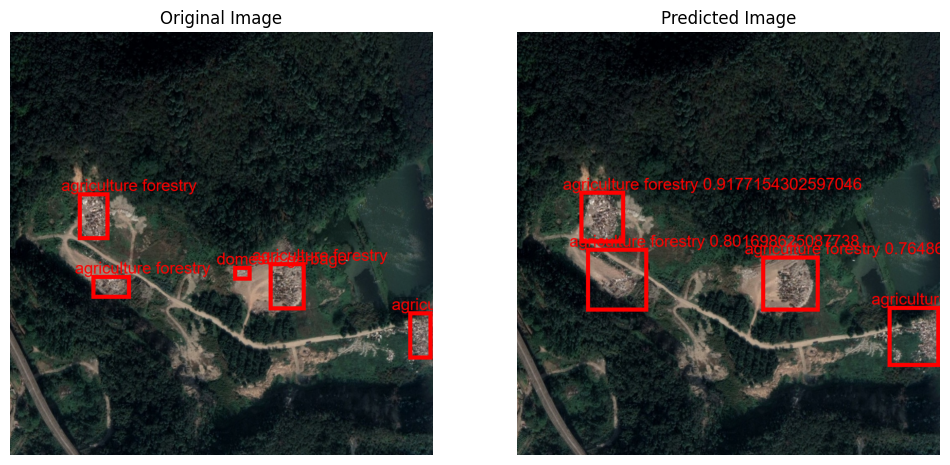

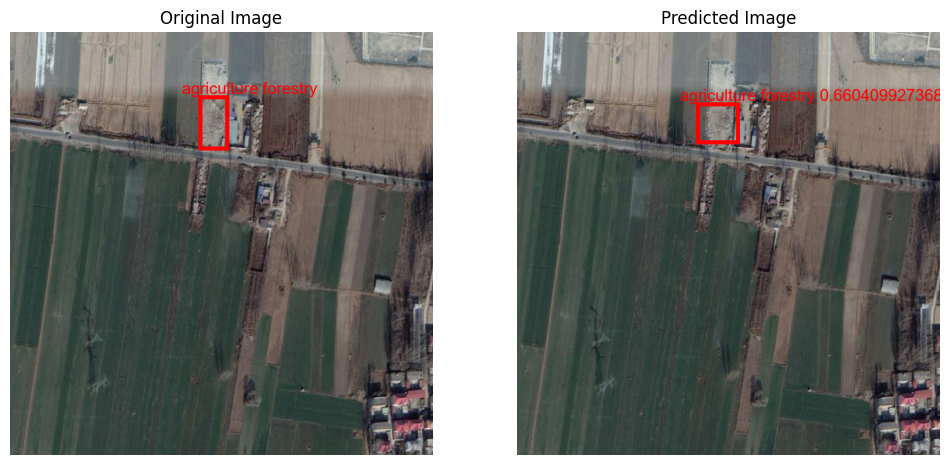

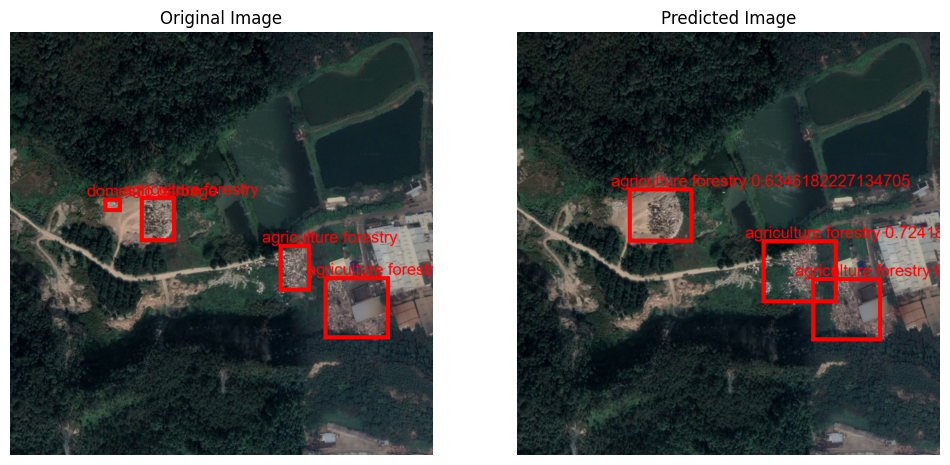

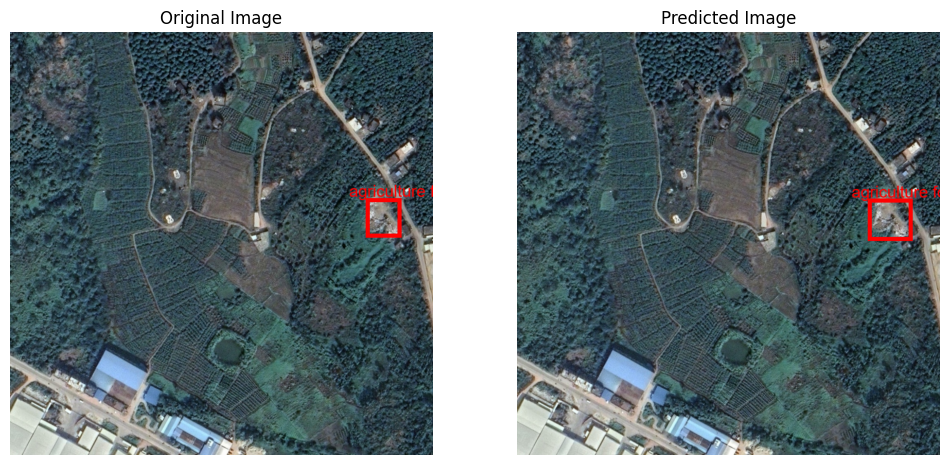

In [315]:
for index, s_output in enumerate(output):
    ori_image = dis_ori_pic(imgs_torch[index], targets[index])
    boxes, labels, scores = decode_output(s_output, 0.2, 0.3)
    image = plot_boxes_scores_labels(imgs_torch[index], boxes, scores, labels)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(ori_image)
    axes[0].axis("off")
    axes[0].set_title("Original Image")
    axes[1].imshow(image)
    axes[1].axis("off")
    axes[1].set_title("Predicted Image")

In [ ]:
model_path = torch.load("final_model.pth")
model.load_state_dict(model_path['model_state_dict'])
model.to(device)

## resnet_model_test 部分

In [386]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

num_labels = {
    0: 100,
    1: 200,
    2: 300,
    3: 400
}

labels = []
for label, count in num_labels.items():
    labels.extend([label] * count)

# 计算每个类别的样本权重
class_sample_counts = [labels.count(i) for i in range(4)]  # 每个类别的样本数量
total_samples = len(labels)
class_weights = [total_samples / count for count in class_sample_counts]  # 权重与样本数量的倒数成正比

# 计算每个样本的权重
sample_weights = [class_weights[label] for label in labels]
print(class_weights)
# 创建 WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# 创建 DataLoader
dataset = torch.utils.data.TensorDataset(torch.tensor(labels))  # 示例数据集
dataloader = DataLoader(dataset, batch_size=16, sampler=sampler)
count_0 = 0
count_1 = 0
count_2 = 0
count_3 = 0
# 使用 DataLoader
for batch in dataloader:
    batch_labels = batch[0].numpy()
    count_0 += (batch_labels == 0).sum()
    count_1 += (batch_labels == 1).sum()
    count_2 += (batch_labels == 2).sum()
    count_3 += (batch_labels == 3).sum()
print(f"标签 0 出现的次数：{count_0}")
print(f"标签 1 出现的次数：{count_1}")
print(f"标签 2 出现的次数：{count_2}")
print(f"标签 3 出现的次数：{count_3}")


[10.0, 5.0, 3.3333333333333335, 2.5]
标签 0 出现的次数：255
标签 1 出现的次数：228
标签 2 出现的次数：257
标签 3 出现的次数：260
